In [7]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import tri as mtri
%matplotlib notebook

In [2]:
class LCSCandidate:
    def __init__(self, manifold):
        max_dist_multiplier = 2


        init_radius = np.linalg.norm(manifold.levelsets[0].points[0].pos-manifold.input_params.init_pos)
        self.points = [Point(manifold.input_params.init_pos)]
        self.points[0].in_ab = True
        self.points[0].weight = np.pi*(0.5*init_radius)**2
        self.points[0].lambda3 = lm3_itp(self.points[0].pos)

        self.avg_lambda3 = 0

        pts_in_ab = []
        pts_not_in_ab = []

        for l in manifold.levelsets:
            for p in l.points:
                if p.in_ab:
                    pts_in_ab.append(p)
                else:
                    pts_not_in_ab.append(p)
        dist_thresh = max_dist_multiplier*manifold.input_params.max_sep

        appended_coords = np.array(self.points[0].pos)

        for p in pts_in_ab:
            if len(appended_coords.shape) == 1:
                if np.linalg.norm(appended_coords - p.pos) < dist_thresh:
                    self.points.append(p)
                    appended_coords = np.vstack((appended_coords,p.pos))
            else:
                if np.any(np.less(np.linalg.norm(appended_coords-p.pos,axis=1),dist_thresh)):
                    self.points.append(p)
                    appended_coords = np.vstack((appended_coords,p.pos))

        for p in pts_not_in_ab:
            if np.any(np.less(np.linalg.norm(appended_coords-p.pos,axis=1),dist_thresh)):
                self.points.append(p)

        tot_weight = 0
        for point in self.points:
            self.avg_lambda3 += point.lambda3*point.weight
            tot_weight += point.weight

        self.avg_lambda3 /= tot_weight

        zmax = np.amax(np.array([p.pos[2] + manifold.input_params.min_sep for p in self.points ]))
        zmin = np.amin(np.array([p.pos[2] - manifold.input_params.min_sep for p in self.points]))

        num_sections = int(np.ceil((zmax-zmin)/(max_dist_multiplier*manifold.input_params.max_sep)))
        d_sec = (zmax-zmin)/num_sections
        #print('num_sections =', num_sections)
        sections = []
        for i in range(num_sections):
            sections.append([])
        #print('len(sections) =', len(sections))

        #print('5*max_sep =', 2.5*manifold.input_params.max_sep, 'zmax-zmin =', zmax - zmin)


        for p in self.points:
            ind = int(np.divmod((p.pos[2]-zmin),d_sec)[0])
            #print('ind =', ind)
            sections[ind].append(p.pos)
            if (np.divmod((p.pos[2]-zmin),d_sec)[1]/d_sec > 0.9 and ind+1 < len(sections)):
                sections[ind+1].append(p.pos)
            elif (np.divmod((p.pos[2]-zmin),d_sec)[1]/d_sec < 0.1 and ind > 0):
                sections[ind-1].append(p.pos)
        for i in range(len(sections)):
            sections[i] = np.array(sections[i])

        triangulations = []
        self.xs = []
        self.ys = []
        self.zs = []
        for sec in sections:
            if (sec.shape[0] >= 3):
                #print('shape =', sec.shape)
                self.xs.append(np.array(sec[:,0]))
                self.ys.append(np.array(sec[:,1]))
                self.zs.append(np.array(sec[:,2]))
                triangulations.append(mtri.Triangulation(self.xs[-1],self.ys[-1]))
        self.triangulations = []

        nrms = np.empty(3)
        for i in range(len(triangulations)):
            self.triangulations.append([])
            for l in range(len(triangulations[i].triangles)):
                    p0 = np.array([self.xs[i][triangulations[i].triangles[l][0]],
                                   self.ys[i][triangulations[i].triangles[l][0]],
                                   self.zs[i][triangulations[i].triangles[l][0]]])
                    p1 = np.array([self.xs[i][triangulations[i].triangles[l][1]],
                                   self.ys[i][triangulations[i].triangles[l][1]],
                                   self.zs[i][triangulations[i].triangles[l][1]]])
                    p2 = np.array([self.xs[i][triangulations[i].triangles[l][2]],
                                   self.ys[i][triangulations[i].triangles[l][2]],
                                   self.zs[i][triangulations[i].triangles[l][2]]])

                    nrms[0] = np.linalg.norm(p0-p1)
                    nrms[1] = np.linalg.norm(p2-p1)
                    nrms[2] = np.linalg.norm(p0-p2)

                    if np.all(np.less_equal(nrms,dist_thresh)):
                        self.triangulations[i].append(triangulations[i].triangles[l])

In [3]:
class Point:
    """A class of which a collection of instances parametrizes a 
    geodesic level set.
    
    Methods defined here:
    
    Point.__init__(level_num, dist, input_params, prev_set)
    Point._find_ordinary_point(index, prev_set, input_params, dist, inbetween)
    Point._find_difficult_point(index, prev_set, input_params, dist, inbetween, 
                                plane_tol, s_offset, ang_offset)
    Point._check_ab()
    Point._prepare_iteration(s_start, interp, s_lower, s_upper, dist, plane_tol, 
                             prev_point, input_params, s_offset, ang_offset)
    Point._iterative_search(s_start, interp, s, ds, trial_dist, overshoot, hit,
                            backtracked, s_lower, s_upper, pos_curr, tan_vec, 
                            dist, plane_tol, prev_point, input_params, s_offset, 
                            ang_offset)
    Point._find_point(s, interp, s_start, s_lower, s_upper, dist, plane_tol, 
                      prev_point, input_params, s_offset, ang_offset)
    Point._next_s(s_start, s, ds, trial_dist, dist, overshoot, hit, backtracked, 
                  input_params)
    Point._compute_pos_aim(prev_pos, dist, prev_prev_vec, tan_vec, ang_offset)
    Point._weighted_prev_vec(index, prev_set, s_lower, s_prev, s_upper)
    Point._weighted_tan_vec(index, prev_set, s_lower, s_prev, s_upper)

    """
    def __init__(self, pos, prev_vec = None, tan_vec = None):
        """Point.__init__(pos, prev_vec, tan_vec)
        
        Constructor for a Point object.
        
        *** This function is called by various other methods
            (classmethods or otherwise) of the Point class ***
        
        param: pos --      (NumPy) array specifying the (Cartesian) point coordinates
        param: prev_vec -- Normalized vector, as a (NumPy) array, specifying the direction 
                           of the straight line from the previous point to this one. 
        param: tan_vec --  Normalized vector, as a (NumPy) array, specifying the local
                           tangential vector, used in order to define a half-plane
                           'radially' outwards from _this_ point.
                           
        """
        # Remember my position
        self.pos = pos
        # Remember my "previous" vector
        self.prev_vec = prev_vec
        # Remember my "tangential" vector
        self.tan_vec = tan_vec
        
        # The following member variables are not set upon construction,
        # as they are not needed prior to the LCS candidate selection 
        # process. Nevertheless, 'allocating' them decreases the 
        # indexing speed later, alas:
        # Remember if I satisfy conditions A, B, and D
        self.in_ab = None
        # Remember my lambda3 value
        self.lambda3 = None
        # Remember my "weight" (~ surrounding area)
        self.weight = None
    
    @classmethod
    def _find_ordinary_point(cls, index, prev_set, input_params, dist, inbetween):
        """Point._find_ordinary_point(index, prev_set, input_params, dist, inbetween)
        
        Attempts to find a point in a new level set by conventional means.
        
        If this does not succeed, internal exception-handling occurs.
        
        If a new point cannot be found by conventional nor unconventional means, 
        descriptive RuntimeErrors are raised. 
        
        *** This function is called by methods further upwards in the hierarchy,
            namely at GeodesicLevelSet level. Explicitly calling this function
            should never be necessary and is not advised in general ***
        
        param: index --        Index of point in previous geodesic level set, from which
                               one attempts to find a point in a new set.
        param: prev_set --     The most recently computed (and accepted) GeodesicLevelSet 
                               instance
        param: input_params -- An InputGeodesicParameters instance, containing 
                               a set of parameters which define the parametrization
                               of the manifold, of which this GeodesicLevelSet is a
                               constituent part. See the InputGeodesicParameters
                               docstring for details.
        param: dist --         The (Euclidean) distance from each point in 
                               the immediately preceding level set, at which
                               one wants to find a new level set.     
        param: inbetween --    Boolean flag indicating whether or not the new point should
                               be constructed from a ficticious (as in, interpolated) 
                               point inbetween neighboring points in the previous level set                               
                               
        return: newp -- The computed point in the new level set. 
        
        """
        
        plane_tol   = input_params.plane_tol  
        s_upper     = prev_set.interpolation.s[np.divmod(index+1,len(prev_set.points))[1]]

        if (inbetween):
            s_lower     = prev_set.interpolation.s[index]
            s_prev      = np.divmod(s_lower + min(abs(s_upper - s_lower),abs(s_upper - s_lower + 1))/2,1)[1]
            prev_point  = cls(prev_set.interpolation(s_prev), 
                              cls._weighted_prev_vec(index,prev_set, s_lower, s_prev, s_upper),
                              cls._weighted_tan_vec(index,prev_set,s_lower,s_prev,s_upper)
                             )            
        
        else:
            s_lower     = prev_set.interpolation.s[np.divmod(index-1,len(prev_set.points))[1]]
            s_prev      = prev_set.interpolation.s[index]
            prev_point  = prev_set.points[index]

        # Prepare initial conditions for iteration by moving a small step along the previous geodesic circle
        # and computing the distance separating the corresponding in-plane point from the start point
        s, ds, trial_dist, pos_curr, tan_vec, overshoot, hit, backtracked = Point._prepare_iteration(s_prev,
                                                                                                    prev_set.interpolation,
                                                                                                    s_lower,
                                                                                                    s_upper,
                                                                                                    dist,
                                                                                                    plane_tol,
                                                                                                    prev_point,
                                                                                                    input_params)
        
        
        # Try to find a satisfying distance (dist) by iteratively moving around the previous geodesic 
        # circle and computing trajectories in the manifold pointed towards our best guess for the new point
        pos_curr, tan_vec, valid_point = Point._iterative_search(s_prev, prev_set.interpolation, s, ds, trial_dist,
                                                               overshoot, hit, backtracked, s_lower, s_upper,
                                                               pos_curr, tan_vec, dist, plane_tol, prev_point,
                                                               input_params
                                                              )
        
        if (valid_point):
            newp = cls(pos_curr, cy_normalize(pos_curr-prev_point.pos), tan_vec)
        else:
            raise PointNotFoundError('Point not found, throwing shit at the wall')
        return newp
    
    @classmethod
    def _find_difficult_point(cls, index, prev_set, input_params, dist, inbetween, plane_tol, s_offset, ang_offset):
        """Point._find_ordinary_point(index, prev_set, input_params, dist, inbetween)
        
        Attempts to find a point in a new level set by unconventional means.
        
        If this does not succeed, internal exception-handling occurs.
        
        If a new point cannot be found descriptive RuntimeErrors are raised. 
        
        This function is never called _before_ _find_ordinary_point.
        
        *** This function is called by methods further upwards in the hierarchy,
            namely at GeodesicLevelSet level. Explicitly calling this function
            should never be necessary and is not advised in general ***
        
        param: index --        Index of point in previous geodesic level set, from which
                               one attempts to find a point in a new set.
        param: prev_set --     The most recently computed (and accepted) GeodesicLevelSet 
                               instance
        param: input_params -- An InputGeodesicParameters instance, containing 
                               a set of parameters which define the parametrization
                               of the manifold, of which this GeodesicLevelSet is a
                               constituent part. See the InputGeodesicParameters
                               docstring for details.
        param: dist --         The (Euclidean) distance from each point in 
                               the immediately preceding level set, at which
                               one wants to find a new level set.     
        param: inbetween --    Boolean flag indicating whether or not the new point should
                               be constructed from a ficticious (as in, interpolated) 
                               point inbetween neighboring points in the previous level set
        param: plane_tol --    Numerical tolerance for detecting whether or not a suggested
                               new point lies within a half-plane extending radially outwards
                               from the corresponding point in the previous level set
        param: s_offset --     Arclength parameter used in order to compute an approximation
                               of a tangential vector by means of a B-spline interpolation
                               of the preceding level set
        param: ang_offset --   Angular offset (in radians) of the point in the aforementioned
                               half-plane at which one aims, wrt the local 'pseudoradial' vector
                               in the previous level set
                               
        return: newp -- The computed point in the new level set. 
        return: best_trial_dist -- The (Euclidean) distance separating newp and the corresponding
                                   point in the previous level set
        return: valid_point --     Boolean flag as to whether or not newp lies within the half-plane
                                   extending radially outwards from the corresponding point in the
                                   previous level set, with a satisfactory separation (Euclidean norm)
                                   between it and the corresponding point.
        
        """
        if (inbetween): 
                s_lower     = prev_set.interpolation.s[index]
                s_upper     = prev_set.interpolation.s[np.divmod(index+1,len(prev_set.points))[1]]
                s_prev      = np.divmod(s_lower + min(abs(s_upper - s_lower), abs(s_upper - s_lower + 1))/2, 1)[1]
        
        else:
                s_lower     = prev_set.interpolation.s[np.divmod(index-1,len(prev_set.points))[1]]
                s_upper     = prev_set.interpolation.s[np.divmod(index+1,len(prev_set.points))[1]]
                s_prev      = prev_set.interpolation.s[index]
            
        prev_point  = cls(prev_set.interpolation(s_prev), 
                          cls._weighted_prev_vec(index, prev_set, s_lower, s_prev, s_upper), 
                          cls._weighted_tan_vec(index, prev_set, s_lower, s_prev, s_upper))

        # Prepare initial conditions for iteration by moving a small step along the previous geodesic circle and
        # computing the distance separating the corresponding in-plane point from the start point
        s, ds, trial_dist, pos_curr, tan_vec, overshoot, hit, backtracked = Point._prepare_iteration(s_prev,
                                                                                                    prev_set.interpolation,
                                                                                                    s_lower,
                                                                                                    s_upper,
                                                                                                    dist,
                                                                                                    plane_tol,
                                                                                                    prev_point,
                                                                                                    input_params,
                                                                                                    s_offset,
                                                                                                    ang_offset
                                                                                                   )
        # Try to find a satisfying distance (dist) by iteratively moving around the previous geodesic circle and 
        # computing trajectories in the manifold pointed towards our best guess for the new point 
        best_pos_curr, best_tan_vec, best_trial_dist, valid_point = Point._iterative_search(s_prev,
                                                                                           prev_set.interpolation,
                                                                                           s,
                                                                                           ds,
                                                                                           trial_dist,
                                                                                           overshoot, 
                                                                                           hit,
                                                                                           backtracked,
                                                                                           s_lower,
                                                                                           s_upper,
                                                                                           pos_curr,
                                                                                           tan_vec,
                                                                                           dist,
                                                                                           plane_tol,
                                                                                           prev_point,
                                                                                           input_params,
                                                                                           s_offset,
                                                                                           ang_offset)

        return cls(best_pos_curr, cy_normalize(pos_curr-prev_point.pos), best_tan_vec), best_trial_dist, valid_point
    
    def _is_in_ab(self):
        """Point._is_in_ab()
        
        Checks whether or not the point satisfies the A and B criteria
        for strong LCSs.
        
        The boolean flag 'in_ab' is set to True or False, accordingly.
        
        """
        A = lm3_itp(self.pos) > lm2_itp(self.pos) and lm3_itp(self.pos) > 1
        B = np.linalg.multi_dot((xi3_itp(self.pos),lm3_itp.hess(self.pos),xi3_itp(self.pos))) <= 0
        #B = xi3_itp(self.pos).dot(lm3_itp.hess(self.pos).dot(xi3_itp(self.pos))) <= 0
                
        self.in_ab = A and B

    

#############################################################################################################                    
############################################# Work functions ################################################
#############################################################################################################

    @staticmethod
    def _prepare_iteration(s_start, interp, s_lower, s_upper, dist, plane_tol, prev_point, input_params, 
                          s_offset=-1, ang_offset=0):
        """Point._prepare_iteration(s_start, interp, s_lower, s_upper, dist, plane_tol,
                                    prev_point, input_params, s_offset, ang_offset)
                                    
        A function which initializes a set of search parameters and boolean variables
        for later use in _iterative_search.
        
        *** This function is called by other classmethods in the Point hierarchy. 
            Explicitly calling this function elsewhere should never be
            necessary and is generally not advised. ***
            
        param: s_start --      The initial value for the s parameter, i.e., 
                               the independent pseudo-arclength parameter 
                               used to interpolate the previous level set.
                               Corresponds to 'prev_point'. 
        param: interp --       (B-spline) interpolation curve of the previous level set
        param: s_lower --      The lower permitted limit for the s parameter
        param: s_upper --      The upper permitted limit for the s parameter
        param: dist --         The (Euclidean) distance from each point in 
                               the immediately preceding level set, at which
                               one wants to find a new level set.     
        param: plane_tol --    Numerical tolerance for detecting whether or not a suggested
                               new point lies within a half-plane extending radially outwards
                               from the corresponding point in the previous level set
        param: prev_point --   The Point instance within the most recently computed (and
                               accepted) geodesic level set, from which one wants to
                               compute a point in the new set
        param: input_params -- An InputGeodesicParameters instance, containing 
                               a set of parameters which define the parametrization
                               of the manifold, of which this GeodesicLevelSet is a
                               constituent part. See the InputGeodesicParameters
                               docstring for details.
        param: s_offset --     Arclength parameter used in order to compute an approximation
                               of a tangential vector by means of a B-spline interpolation
                               of the preceding level set. Defaults to -1, which corresponds
                               to a conventional approach. 
        param: ang_offset --   Angular offset (in radians) of the point in the aforementioned
                               half-plane at which one aims, wrt the local 'pseudoradial' vector
                               in the previous level set. Defaults to 0.
                               
        return: s --           New pseudo-arclength parameter describing (by means of the B-spline 
                               B-spline interpolated preceding level set) the point on the previous
                               level set from which the search for a new point in the new level set
                               is to begin
        return: ds --          Step length along the s abscissa when multiple attempts are
                               required
        return: trial_dist --  (Euclidean) distance separating prev_point and a first
                               approximation of the new point. Defaults to -1 if the
                               first approximation fails.
        return: pos_curr --    (NumPy) array of Cartesian coordinates of the first approximation
                               of the new point
        return: tan_vec --     Normalized vector (as a NumPy array) which is approximately
                               tangent to prev_point (when the previous geodesic level set
                               is viewed as a whole)
        return: overshoot --   Boolean parameter indicating whether or not the most recent
                               approximation overshot wrt the distance from the previous point.
                               As this function merely performs preparations, overshoot == False
        return: hit --         Boolean parameter indicating whether or not the most recent
                               approximation hit the target plane. As this function
                               merely performs preparations, hit == True
        return: backtracked -- Boolean parameter indicating whether or not the most recent
                               attempt at finding a new point involved backtracking in terms
                               of the s parameter. Relevant whenever overshoot = True.
                               As this function merely performs preparations, 
                               backtracked == False
                               
        """
   
        # Find new (previous) level circle parameter (s) from which to search for new point
        s = s_start + input_params.min_s_step
        ds = input_params.min_s_step
        overshoot = False
        hit = True
        backtracked = False

        # Search for point in half-plane defined by previous point and circle tangent
        pos_curr, tan_vec, success = Point._find_point(s, interp, s_start, s_lower, s_upper, dist, plane_tol,
                                                      prev_point, input_params, s_offset, ang_offset)

        if (success):
            trial_dist = cy_norm2(pos_curr-prev_point.pos)
            #trial_dist = np.linalg.norm(pos_curr-prev_point.pos)
        else:
            trial_dist = -1
        return s, ds, trial_dist, pos_curr, tan_vec, overshoot, hit, backtracked
    
    # Iteratively search for acceptable new point
    def _iterative_search(s_start, interp, s, ds, trial_dist, overshoot, hit, backtracked, s_lower, s_upper, 
                         pos_curr, tan_vec, dist, plane_tol, prev_point, input_params, s_offset=-1, ang_offset=0):
        """Point._iterative_search(s_start, interp, s, ds, trial_dist, overshoot, hit, backtracked,
                                   s_lower, s_upper, pos_curr, tan_vec, dist, plane_tol, prev_point,
                                   input_params, s_offset, ang_offset)
        
        Searches for a new point in a new geodesic level set iteratively.
        
        *** This function is called by other classmethods in the Point hierarchy. 
            Explicitly calling this function elsewhere should never be
            necessary and is generally not advised. ***
        
        param: s_start --      The initial value for the s parameter, i.e., 
                               the independent pseudo-arclength parameter 
                               used to interpolate the previous level set.
                               Corresponds to 'prev_point'. 
        param: interp --       (B-spline) interpolation curve of the previous level set
        param: s --            Pseudo-arclength parameter describing (by means of the B-spline 
                               B-spline interpolated preceding level set) the point on the previous
                               level set from which the search for a new point in the new level set
                               is to begin. (As computed in _prepare_iteration)
        param: ds --           Step length along the s abscissa when multiple attempts are
                               required
        param: trial_dist --   (Euclidean) distance separating prev_point and the previous
                               approximation of the new point. The first approximation is
                               computed in _prepare_iteration
        param: overshoot --    Boolean parameter indicating whether or not the most recent
                               approximation overshot wrt the distance from the previous point
        param: hit --          Boolean parameter indicating whether or not the most recent
                               approximation hit the target plane
        param: backtracked --  Boolean parameter indicating whether or not the most recent
                               attempt at finding a new point involved backtracking in terms
                               of the s parameter.
        param: s_lower --      The lower permitted limit for the s parameter
        param: s_upper --      The upper permitted limit for the s parameter     
        param: pos_curr --     (NumPy) array of Cartesian coordinates of the most recent 
                               approximation of the new point
        param: tan_vec --      Normalized vector (as a NumPy array) which is approximately
                               tangent to prev_point (when the previous geodesic level set
                               is viewed as a whole)
        param: dist --         The (Euclidean) distance from each point in 
                               the immediately preceding level set, at which
                               one wants to find a new level set. 
        param: plane_tol --    Numerical tolerance for detecting whether or not a suggested
                               new point lies within a half-plane extending radially outwards
                               from the corresponding point in the previous level set
        param: prev_point --   The Point instance within the most recently computed (and
                               accepted) geodesic level set, from which one wants to
                               compute a point in the new set      
        param: input_params -- An InputGeodesicParameters instance, containing 
                               a set of parameters which define the parametrization
                               of the manifold, of which this GeodesicLevelSet is a
                               constituent part. See the InputGeodesicParameters
                               docstring for details.      
        param: s_offset --     Arclength parameter used in order to compute an approximation
                               of a tangential vector by means of a B-spline interpolation
                               of the preceding level set. A conventional search is performed
                               when s_offset != -1.
        param: ang_offset --   Angular offset (in radians) of the point in the aforementioned
                               half-plane at which one aims, wrt the local 'pseudoradial' vector
                               in the previous level set. A conventional approach is performed
                               when ang_offset != 0.
        
        return: pos_curr --        (NumPy) array containing the Cartesian coordinates of the best
                                   approximation of the new point. 
        return: tan_vec --         Normalized vector (as a NumPy array) which is approximately
                                   tangent to prev_point and resulted in the best approximation
                                   pos_curr
        return: best_trial_dist -- ***IF ang_offset != 0***, the (Euclidean) distance separating
                                   pos_curr and prev_point
        return: valid_point --     Boolean flag indicating whether or not pos_curr satisfies
                                   numerical tolerance parameters included in input_params 
        
        """
        # Look for new point in plane defined by previous point and circle tangent until one is found at an
        # appropriate distance from the previous point
        best_trial_dist = trial_dist
        best_pos_curr = pos_curr
        best_tan_vec = tan_vec
        while((trial_dist < dist*(1-input_params.dist_tol) or trial_dist > dist*(1+input_params.dist_tol)) 
              and s < s_start + 1 and (s > s_start + 0.9 or ds > 0)):
            
            # Find new (previous) level circle parameter (s) from which to search for new point
            s, ds, overshoot, hit, backtracked = Point._next_s(s_start, s, ds, trial_dist, dist, overshoot,
                                                              hit, backtracked, input_params)
            # Search for point in half-plane defined by previous point and circle tangent
            pos_curr, tan_vec, success = Point._find_point(s, interp, s_start, s_lower, s_upper, dist, plane_tol,
                                                              prev_point, input_params, s_offset, ang_offset)
            
            if (success):
                trial_dist = cy_norm2(pos_curr-prev_point.pos)
                #trial_dist = np.linalg.norm(pos_curr-prev_point.pos)
                if (abs(trial_dist-dist) < abs(best_trial_dist-dist)):
                    best_trial_dist = trial_dist
                    best_pos_curr = pos_curr
                    best_tan_vec = tan_vec
            else:
                trial_dist = -1
        valid_point = (trial_dist > dist*(1-input_params.dist_tol) and trial_dist < dist*(1+input_params.dist_tol))            
        if (ang_offset == 0):
            return pos_curr, tan_vec, valid_point
        else:
            return best_pos_curr, best_tan_vec, best_trial_dist, valid_point

    # Attempting to "advect" the current position towards the half plane originating from the start position
    @staticmethod
    def _find_point(s, interp, s_start, s_lower, s_upper, dist, plane_tol, prev_point, input_params,
                                                                       s_offset=-1, ang_offset=0):
        """Point._find_point(s, interp, s_start, s_lower, s_upper, dist, plane_tol,
                             prev_point, input_params, s_offset, ang_offset)
           
        Computes trajectories orthogonal to a three-dimensional vector field 
        from point A to point B, by means of the Dormand-Prince 5(4) 
        numerical integrator.
        
        *** This function is called (recursively) by other classmethods in the
        Point hierarchy. Explicitly calling this function elsewhere should
        never be necessary and is generally not advised. ***

        param: s --            Pseudo-arclength parameter describing (by means of the B-spline 
                               B-spline interpolated preceding level set) the point on the previous
                               level set from which the search for a new point in the new level set
                               is to begin. (As computed in _prepare_iteration)
        param: interp --       (B-spline) interpolation curve of the previous level set
        param: s_start --      The initial value for the s parameter, i.e., 
                               the independent pseudo-arclength parameter 
                               used to interpolate the previous level set.
                               Corresponds to 'prev_point'. 
        param: s_lower --      The lower permitted limit for the s parameter
        param: s_upper --      The upper permitted limit for the s parameter   
        param: dist --         The (Euclidean) distance from each point in 
                               the immediately preceding level set, at which
                               one wants to find a new level set. 
        param: plane_tol --    Numerical tolerance for detecting whether or not a suggested
                               new point lies within a half-plane extending radially outwards
                               from the corresponding point in the previous level set        
        param: prev_point --   The Point instance within the most recently computed (and
                               accepted) geodesic level set, from which one wants to
                               compute a point in the new set
        param: input_params -- An InputGeodesicParameters instance, containing 
                               a set of parameters which define the parametrization
                               of the manifold, of which this GeodesicLevelSet is a
                               constituent part. See the InputGeodesicParameters
                               docstring for details.
        param: s_offset --     Arclength parameter used in order to compute an approximation
                               of a tangential vector by means of a B-spline interpolation
                               of the preceding level set. Defaults to -1, which corresponds
                               to a conventional approach, where a variety of s intervals is
                               attempted when computing an (approximately) tangential vector
                               to prev_point by means of the B-spline interpolated curve. 
                               s_offset != -1 is used directly to compute the aforementioned
                               tangential vector. 
        param: ang_offset --   Angular offset (in radians) of the point in the aforementioned
                               half-plane at which one aims, wrt the local 'pseudoradial' vector
                               in the previous level set. Defaults to 0.
                               
        return: pos_curr --    New approximation of the new point in the new geodesic level set
        return: tan_vec --     Tangential vector which was used to compute pos_curr
        return: in_plane --    Boolean flag indicating whether or not pos_curr is located in
                               the half-plane defined as being orthogonal to tan_vec,
                               and extending outwards radially from prev_point

        """
        #pos_curr = np.array(scp_splev(np.divmod(u,1)[1],tck))
        pos_curr = interp(np.divmod(s,1)[1])
        if (s_offset == -1):
            best_tan_vec = prev_point.tan_vec
            best_dot_prod = 0
            #for ds in [0.01, 0.05, 0.1, 0.15, 0.2, 0.25]:
            for ds in [0.01,0.05,0.1,0.15, 0.2, 0.25]:
                lower_pos = interp(np.divmod(s_start-ds,1)[1])
                upper_pos = interp(np.divmod(s_start+ds,1)[1])
                tan_vec = cy_normalize(upper_pos - lower_pos)
                if (abs(np.dot(tan_vec,prev_point.tan_vec)) >= 1-input_params.tan_tol):
                    best_tan_vec = tan_vec
                    best_dot_prod = abs(np.dot(tan_vec, prev_point.tan_vec))
                    break
                elif (abs(np.dot(tan_vec, prev_point.tan_vec)) > best_dot_prod):
                    best_tan_vec = tan_vec
                    best_dot_prod = abs(np.dot(tan_vec, prev_point.tan_vec))
            tan_vec = best_tan_vec
        else:
            ds = s_offset
            lower_pos = interp(np.divmod(s_start-ds,1)[1])
            upper_pos = interp(np.divmod(s_start+ds,1)[1])
            tan_vec = cy_normalize(upper_pos - lower_pos)
        
        pos_aim = cy_compute_pos_aim(prev_point.pos, dist, prev_point.prev_vec, tan_vec, ang_offset)
        
        # Parameters:
        max_arclen_factor = 3
        init_stride = 0.1*dist
        
        start_dist = cy_norm2(pos_aim-pos_curr)
        max_arclen = max_arclen_factor*start_dist
        arclen = 0
        stride = init_stride
        
        direction_generator.set_target(pos_aim)
        dp54_p.set_aim_assister(direction_generator)
        while(not (cy_in_plane(pos_curr, prev_point.pos, tan_vec, prev_point.prev_vec, plane_tol)
                   and (cy_norm2(prev_point.pos-pos_curr) < dist*(1+input_params.dist_tol)
                        and cy_norm2(prev_point.pos-pos_curr) > dist*(1-input_params.dist_tol)))
              and cy_norm2(pos_aim - pos_curr) <= start_dist and arclen<max_arclen):
            stride = cy_min(stride, cy_norm2(pos_curr - pos_aim))
            arclen, pos_curr, stride = dp54_p(arclen, pos_curr, stride)
        
        direction_generator.unset_target()
        dp54_p.unset_aim_assister()
        return pos_curr, tan_vec, cy_in_plane(pos_curr,prev_point.pos, tan_vec, prev_point.prev_vec, plane_tol)#(Point.in_plane(pos_curr, prev_point, tan_vec, plane_tol))

    # Suggest a new geodesic level circle parameter s, from which to search for a new acceptable point
    @staticmethod
    def _next_s(s_start, s, ds, trial_dist, dist, overshoot, hit, backtracked, input_params):
        """Point._next_s(s_start, s, ds, trial_dist, dist, overshoot, hit, backtracked,
                         input_params)
                         
        A function which suggests a new geodesic level set pseudo-arclength parameter s,
        from which to start a new search for an acceptable point.
        
        *** This function is called (recursively) by other classmethods in the
        Point hierarchy. Explicitly calling this function elsewhere should
        never be necessary and is generally not advised. ***
        
        param: s_start --      The initial value (as in most recently used) for the s parameter, i.e., 
                               the independent pseudo-arclength parameter 
                               used to interpolate the previous level set.
                               Corresponds to 'prev_point'. 
        param: interp --       (B-spline) interpolation curve of the previous level set
        param: s --            Pseudo-arclength parameter describing (by means of the B-spline 
                               B-spline interpolated preceding level set) the point on the previous
                               level set from which the search for a new point in the new level set
                               is to begin. (As computed in _prepare_iteration)
        param: ds --           Step length along the s abscissa when multiple attempts are
                               required
        param: trial_dist --   (Euclidean) distance separating the point in the most recently
                               computed (and accepted) geodesic level set, and the newest
                               approximation of the new point.
        param: dist --         The (Euclidean) distance from each point in 
                               the immediately preceding level set, at which
                               one wants to find a new level set.                               
        param: overshoot --    Boolean parameter indicating whether or not the most recent
                               approximation overshot wrt the distance from the previous point
        param: hit --          Boolean parameter indicating whether or not the most recent
                               approximation hit the target plane.
        param: backtracked --  Boolean parameter indicating whether or not the most recent
                               attempt at finding a new point involved backtracking in terms
                               of the s parameter. 
        param: input_params -- An InputGeodesicParameters instance, containing 
                               a set of parameters which define the parametrization
                               of the manifold, of which this GeodesicLevelSet is a
                               constituent part. See the InputGeodesicParameters
                               docstring for details.
                               
        return: s --           Updated pseudo-arclength parameter indicating from which
                               point along the most recently computed (and accepted)
                               geodesic level set the next search for a new point
                               should begin
        return: ds --          Updated step length along the s abscissa
        return: overshoot --   Boolean parameter indicating whether or not the most
                               approximation overshot wrt the distance from the previous point
        return: hit --         Boolean parameter indicating whether or not the most
                               recent approximation hit the target plane
        return: backtracked -- Boolean parameter indicating whether or not the most recent 
                               attempt at finding a new point involved backtracking in terms
                               of the s parameter. The truth value may change depending on 
                               whether or not the next s value involves moving in the opposite
                               direction along the s abscissa.
                               
        """
        # Move back to start point and turn direction of iteration when entering farthest half circle
        if (s >= s_start + 0.1 and ds > 0):
            return s_start+1 - input_params.min_s_step, -input_params.min_s_step, False, True, False

        if (hit):
            if (overshoot):
                if (trial_dist < 0):
                    if (abs(ds) > input_params.min_s_step):
                        return s - 0.9*ds, 0.1*ds, overshoot, hit, True
                    else:
                        return s + ds, ds, overshoot, False, False
                elif (trial_dist > dist*(1 + input_params.dist_tol)):
                    if (abs(ds) < input_params.max_s_step):
                        if (backtracked):
                            return s + ds, ds, True, True, backtracked
                        else:
                            return s + 10*ds, 10*ds, True, True, backtracked
                    else: #Should never be backtracked here
                        return s + ds, ds, True, True, False
                else: #(Di < D*(1-Dtol)):
                    if (abs(ds) > input_params.min_s_step):
                        return s - 0.9*ds, 0.1*ds, overshoot, hit, True
                    else:
                        return s + ds, ds, False, True, False
            else: #(not over)
                if (trial_dist < 0):
                    if (abs(ds) > input_params.min_s_step):
                        return s - 0.9*ds, 0.1*ds, overshoot, hit, True
                    else:
                        return s + ds, ds, overshoot, False, False
                elif (trial_dist > dist*(1 + input_params.dist_tol)):
                    if (abs(ds) > input_params.min_s_step):
                        return s - 0.9*ds, 0.1*ds, False, hit, True
                    else:
                        return s + ds, ds, True, True, False
                else: #(Di < D*(1-Dtol)):
                    if (abs(ds) < input_params.max_s_step):
                        if (backtracked):
                            return s + ds, ds, False, True, backtracked
                        else:
                            return s + 10*ds, 10*ds, False, True, backtracked
                    else:
                        return s + ds, ds, False, True, False
        else: # (not hit))
            if (trial_dist < 0):
                if (abs(ds) < input_params.max_s_step):
                    if (backtracked):
                        return s + ds, ds, overshoot, False, backtracked
                    else:
                        return s + 10*ds, 10*ds, overshoot, False, backtracked
                else:
                    return s + ds, ds, overshoot, False, False
            elif (trial_dist > dist*(1 + input_params.dist_tol)):
                if (abs(ds) > input_params.min_s_step):
                    return s - 0.9*ds, 0.1*ds, overshoot, hit, True
                else:
                    if (backtracked):
                        return s + ds, ds, True, True, backtracked
                    else:
                        return s + 10*ds, 10*ds, True, True, backtracked
            else: #(Di < D*(1-Dtol)):
                if (abs(ds) > input_params.min_s_step):
                    return s - 0.9*ds, 0.1*ds, overshoot, hit, True
                else:
                    if (backtracked):
                        return s + ds, ds, False, True, backtracked
                    else:
                        return s + 10*ds, 10*ds, False, True, backtracked
                                    
##################################################################################################
##################################### Helping functions ##########################################
##################################################################################################

    # Computes the position towards which the solver algorithm aims
    @staticmethod
    def _compute_pos_aim(prev_pos, dist, prev_prev_vec, tan_vec, ang_offset):
        """Point._compute_pos_aim(prev_pos, dist, prev_prev_vec, tan_vec, ang_offset)
        
        Computes the position towards which the Dormand-Prince solver algorithm 
        aims, when searching for a new point in a geodesic level set.
        
        param: prev_pos --      (NumPy) array of the Cartesian coordinates of the
                                point in the most recently completed (and accepted)
                                geodesic level set, from which a new point is sought
        param: dist --          The (Euclidean) distance from each point in 
                                the immediately preceding level set, at which
                                one wants to find a new level set.  
        param: prev_prev_vec -- Normalized vector (as a NumPy array) which gives
                                the direction of the straight line between the
                                previous point and _its_ previous point
        param: tan_vec --       Normalized vector (as a NumPy array) which 
                                gives the direction of the tangent passing through
                                prev_pos, when the previous geodesic level set is 
                                considered as a whole
        param: ang_offset --    Angular offset (in radians) of the point in half-plane
                                which is defined as being orthogonal to tan_vec,
                                and extending radially outwards from prev_pos,
                                at which one aims. 
        
        return: pos_aim -- (NumPy) array of the Cartesian coordinates of the point
                           to aim at

        """
        outward_vec = cy_normalize(orthogonalComponent(prev_prev_vec, tan_vec))
        upward_vec = cy_normalize(np.cross(tan_vec, outward_vec))
        return prev_pos + dist*cy_normalize(outward_vec + np.tan(ang_offset)*upward_vec)
    
    # Computes weighted average of "from previous" vectors at neighboring points
    @staticmethod
    def _weighted_prev_vec(index, prev_set, s_lower, s_prev, s_upper):
        """Point._weighted_prev_vec(index, prev_set, u_lower, s_prev, s_upper)
        
        Computes a weighted average of 'from previous' vectors at neighboring 
        points. Relevant when adding points inbetween others in order to
        conform with demands regarding minimum and maximum separation.
        
        param: index --    Index of the point in the previous set (prev_set),
                           after which a new fictitious point is to be generated
                           inbetween index and index+1 in order to compute
                           local radial vectors.
        param: prev_set -- The most recently computed (and accepted)
                           geodesic level set
        param: s_lower --  The lower permitted limit for the s parameter
        param: s_prev --   The s parameter of the parametrization of the
                           previous set, which in the context of the
                           B-spline parametrization of prev_set
                           yields the Cartesian coordinates of the
                           coordinates of prev_set.points[index]
        param: s_upper --  The upper permitted limit for the s parameter
        
        return: wt_vec -- Normalized vector (as a NumPy array) from weighted
                          average of 'from previous' vectors at neighboring 
                          points (namely the ones located at index and index+1)
        
        """
        ds_upper = min(abs(s_upper - s_prev), abs(s_upper - s_prev + 1))
        ds_lower = min(abs(s_prev - s_lower), abs(s_prev - s_lower + 1))              
        return cy_normalize(ds_upper*prev_set.points[np.divmod(index+1,len(prev_set.points))[1]].prev_vec \
                + ds_lower*prev_set.points[index].prev_vec)
    
    # Computes weighted average of tangential vectors at neighboring points
    @staticmethod
    def _weighted_tan_vec(index, prev_set, s_lower, s_prev, s_upper):
        """Point._weighted_tan_vec(index, prev_set, u_lower, s_prev, s_upper)
        
        Computes a weighted average of (approximately) tangential vectors at 
        neighboring points. Relevant when adding points inbetween others in 
        order to conform with demands regarding minimum and maximum separation.
        
        param: index --    Index of the point in the previous set (prev_set),
                           after which a new fictitious point is to be generated
                           inbetween index and index+1 in order to compute
                           local radial vectors.
        param: prev_set -- The most recently computed (and accepted)
                           geodesic level set
        param: s_lower --  The lower permitted limit for the s parameter
        param: s_prev --   The s parameter of the parametrization of the
                           previous set, which in the context of the
                           B-spline parametrization of prev_set
                           yields the Cartesian coordinates of the
                           coordinates of prev_set.points[index]
        param: s_upper --  The upper permitted limit for the s parameter
        
        return: wt_vec -- Normalized vector (as a NumPy array) of the (nearly)
                          tangential vectors at neighboring points
                          (namely the ones located at index and index+1)
        
        """        
        ds_upper = min(abs(s_upper - s_prev), abs(s_upper - s_prev + 1))
        ds_lower = min(abs(s_prev - s_lower), abs(s_prev - s_lower + 1))              
        return cy_normalize(ds_upper*prev_set.points[np.divmod(index+1,len(prev_set.points))[1]].tan_vec \
                + ds_lower*prev_set.points[index].tan_vec)

In [4]:
LCSs = np.load('lcss.npy')

In [5]:
LCSs

array([<__main__.LCSCandidate object at 0x7f2c31f6c898>,
       <__main__.LCSCandidate object at 0x7f2c31eb0eb8>], dtype=object)

<IPython.core.display.Javascript object>


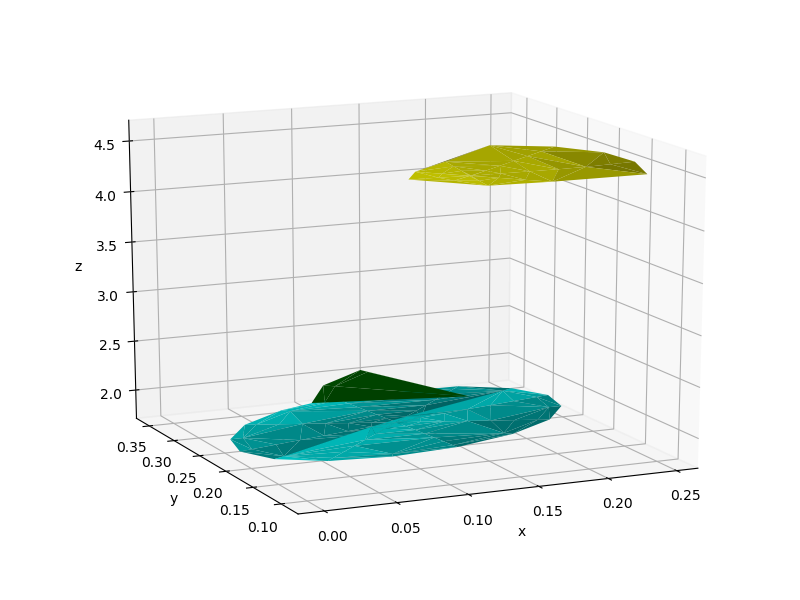

In [8]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')

#s = np.linspace(0,1,1000)

#for l in mfs[1].levelsets[:]:
#    pts = np.array([l.interpolation(s0) for s0 in s])
#    ax.plot(pts[:,0], pts[:,1], pts[:,2])

cs = ['r','c','y','g','r','c','y','g','r','c','y','g','r','c','y','g','r','c','y','g','r','c','y','g',
     'r','c','y','g','r','c','y','g','r','c','y','g','r','c','y','g','r','c','y','g','r','c','y','g']

counter = 0
for LCS in LCSs:
    counter += 1
    for i in range(len(LCS.triangulations)):
        ax.plot_trisurf(LCS.xs[i], LCS.ys[i], LCS.zs[i], color = cs[counter], triangles = LCS.triangulations[i])

#ax.set_title('min_sep$={}$, linear interp={}'.format(min_sep,True))

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.set_xlim(xmin,xmax)
#ax.set_ylim(ymin,ymax)
#ax.set_zlim(zmin,zmax)



plt.tight_layout()

In [11]:
for LCS in LCSs:
    print(np.sum([p.weight for p in LCS.points]))

0.1115491616810136
0.5934493748326514
0.27009782776764274
